# RNN Time Series Forecasting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math

PATH = r"completeLoad.csv"
df = pd.read_csv(PATH)
df_h = df.set_index(['zone_id', 'year', 'month', 'day'])

Using TensorFlow backend.


In [3]:
def plot_history(history, metric = None):
    if metric != None:
        fig, axes = plt.subplots(2,1)
        axes[0].plot(history.history[metric])
        try:
            axes[0].plot(history.history['val_'+metric])
            axes[0].legend(['Train', 'Val'], loc='best')
        except:
            pass
        axes[0].set_title('{:s}'.format(metric))
        axes[0].set_ylabel('{:s}'.format(metric))
        axes[0].set_xlabel('Epoch')
        fig.subplots_adjust(hspace=0.5)
        axes[1].plot(history.history['loss'])
        try:
            axes[1].plot(history.history['val_loss'])
            axes[1].legend(['Train', 'Val'], loc='best')
        except:
            pass
        axes[1].set_title('Model Loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
    else:
        plt.plot(history.history['loss'])
        try:
            plt.plot(history.history['val_loss'])
            plt.legend(['Train', 'Val'], loc='best')
        except:
            pass
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

In [4]:
# 
unfolded_df = {}
for i, x in enumerate(tqdm(df_h.columns.tolist())):
    col_tuple = df_h[x].to_dict()
    for j, k in col_tuple.items():
        unfolded_df[tuple(list(j) + [i+1])] = k

n_df = pd.DataFrame.from_dict(unfolded_df, orient="index").sort_index()
m_index = pd.MultiIndex.from_tuples(unfolded_df.keys())
mi_df = pd.DataFrame(unfolded_df.values(), m_index).sort_index()

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 17.02it/s]


In [5]:
# convert pd.DateFrame to np.array of type float and group by zone.
df_zone = np.array([mi_df.loc[(i+1)].values.astype("float32").reshape(
        len(mi_df.loc[(i+1)]),) for i in range(mi_df.index[-1][0])])

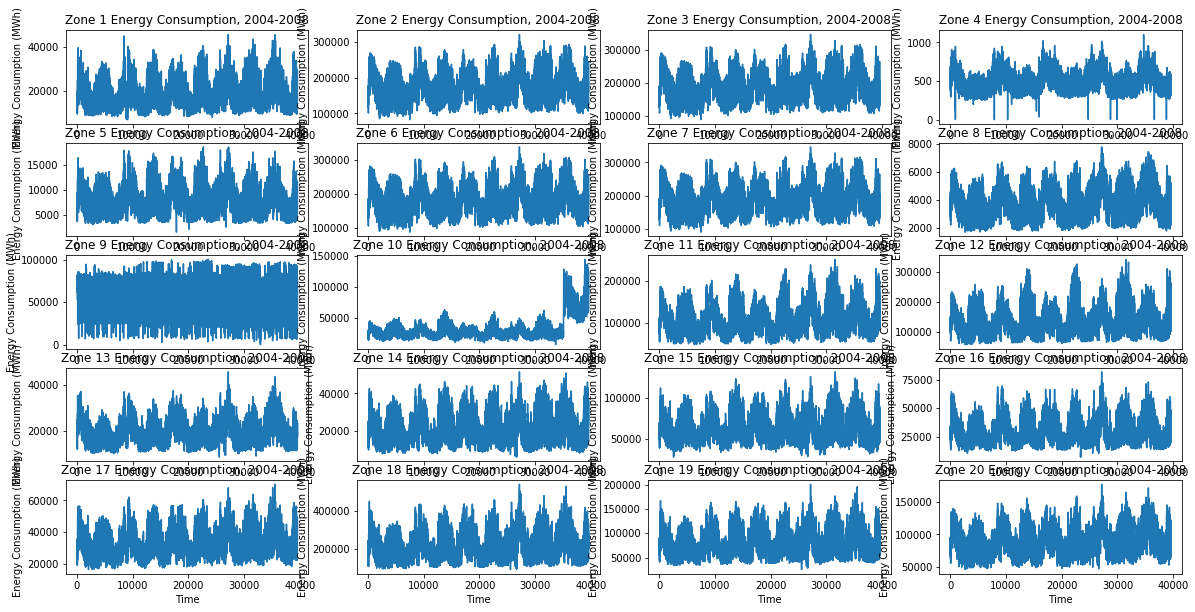

In [6]:
plt.figure(figsize = (20, 10))
for i, x in enumerate(df_zone):
    plt.subplot(5, 4, i+1)
    plt.plot(x)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (MWh)")
    plt.title("Zone {} Energy Consumption, 2004-2008".format(i+1))
plt.show()

In [7]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import pickle

In [8]:
# use data for zone 1.
data = df_zone[0].reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERC = 0.80

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [69]:
# helper function to read data.
def create_dataset(dataset, window_size = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[i + window_size, 0])
    return(np.array(data_x), np.array(data_y))

def create_model(train_X, train_Y, window_size = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(5,input_shape = (1, window_size), ))
    vanilla_rnn.add(Dense(1))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    
    return(vanilla_rnn)

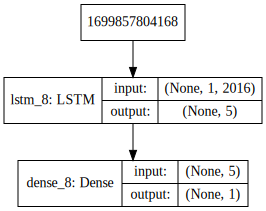

In [75]:
window_size = 24*7*12
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model(train_X, train_Y, window_size)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))

Train on 25196 samples, validate on 4447 samples
Epoch 1/50
 - 6s - loss: 0.0048 - val_loss: 0.0076
Epoch 2/50
 - 3s - loss: 0.0021 - val_loss: 0.0018
Epoch 3/50
 - 5s - loss: 0.0014 - val_loss: 0.0037
Epoch 4/50
 - 4s - loss: 0.0012 - val_loss: 0.0015
Epoch 5/50
 - 5s - loss: 0.0010 - val_loss: 0.0021
Epoch 6/50
 - 4s - loss: 9.6804e-04 - val_loss: 0.0018
Epoch 7/50
 - 4s - loss: 8.0510e-04 - val_loss: 0.0011
Epoch 8/50
 - 4s - loss: 7.4844e-04 - val_loss: 9.2082e-04
Epoch 9/50
 - 4s - loss: 7.6479e-04 - val_loss: 0.0011
Epoch 10/50
 - 3s - loss: 6.7361e-04 - val_loss: 0.0011
Epoch 11/50
 - 3s - loss: 7.0426e-04 - val_loss: 0.0019
Epoch 12/50
 - 3s - loss: 6.2627e-04 - val_loss: 0.0012
Epoch 13/50
 - 3s - loss: 5.9840e-04 - val_loss: 0.0011
Epoch 14/50
 - 3s - loss: 6.0791e-04 - val_loss: 7.6589e-04
Epoch 15/50
 - 3s - loss: 6.0233e-04 - val_loss: 0.0012
Epoch 16/50
 - 3s - loss: 5.8121e-04 - val_loss: 0.0017
Epoch 17/50
 - 3s - loss: 5.3853e-04 - val_loss: 0.0011
Epoch 18/50
 - 4s - 

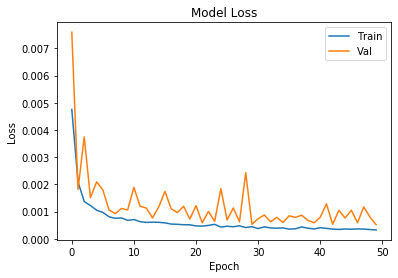

In [76]:
history = vanilla_rnn.fit(train_X, train_Y, epochs = 50, batch_size = 32, verbose = 2, validation_split=0.15)
plot_history(history)

In [77]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def get_naive_hour_predict_and_score(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.hstack((Y[0], Y[0:-1])).reshape(-1, 1))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def get_naive_day_predict_and_score(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.hstack((Y[0:24], Y[0:-24])).reshape(-1, 1))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def get_naive_week_predict_and_score(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.hstack((Y[0:24*7], Y[0:-24*7])).reshape(-1, 1))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

mse_train, train_predict = get_predict_and_score(vanilla_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score(vanilla_rnn, test_X, test_Y)
mse_train_naive_hour, train_predict_naive_hour = get_naive_hour_predict_and_score(train_X, train_Y)
mse_test_naive_hour, test_predict_naive_hour = get_naive_hour_predict_and_score(test_X, test_Y)
mse_train_naive_day, train_predict_naive_day = get_naive_day_predict_and_score(train_X, train_Y)
mse_test_naive_day, test_predict_naive_day = get_naive_day_predict_and_score(test_X, test_Y)
mse_train_naive_week, train_predict_naive_week = get_naive_week_predict_and_score(train_X, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_week_predict_and_score(test_X, test_Y)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("(Naive -1 hour) Training data error: %.2f MSE" % mse_train_naive_hour)
print("(Naive -1 hour) Test data error: %.2f MSE" % mse_test_naive_hour)
print("(Naive -1 day) Training data error: %.2f MSE" % mse_train_naive_day)
print("(Naive -1 day) Test data error: %.2f MSE" % mse_test_naive_day)
print("(Naive -1 week) Training data error: %.2f MSE" % mse_train_naive_week)
print("(Naive -1 week) Test data error: %.2f MSE" % mse_test_naive_week)

Training data error: 642.36 MSE
Test data error: 853.60 MSE
(Naive -1 hour) Training data error: 1442.77 MSE
(Naive -1 hour) Test data error: 1478.30 MSE
(Naive -1 day) Training data error: 2951.79 MSE
(Naive -1 day) Test data error: 3516.40 MSE
(Naive -1 week) Training data error: 4463.22 MSE
(Naive -1 week) Test data error: 5433.01 MSE


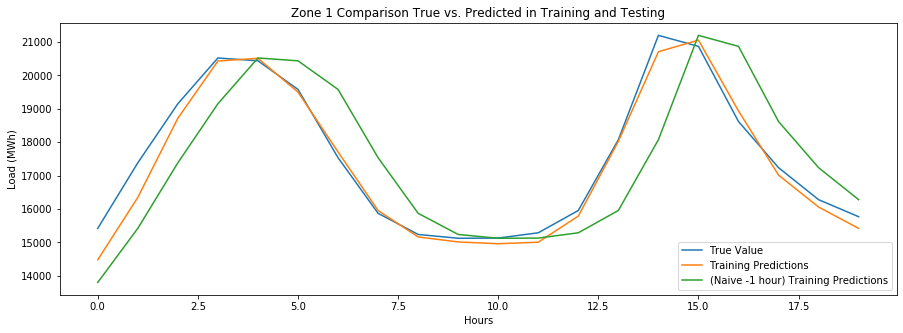

In [78]:
# Training predictions.
train_predictions = np.empty_like(dataset)
train_predictions[:, :] = np.nan
train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

# (Naive -1 hour) Training predictions.
train_predictions_naive_hour = np.empty_like(dataset)
train_predictions_naive_hour[:, :] = np.nan
train_predictions_naive_hour[window_size:len(train_predict_naive_hour) + window_size, :] = train_predict_naive_hour

# Test predictions.
test_predictions = np.empty_like(dataset)
test_predictions[:, :] = np.nan
test_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset)[2200:2220], label = "True Value") # check using [2200:2220]
plt.plot(train_predictions[2200:2220], label = "Training Predictions")
plt.plot(train_predictions_naive_hour[2200:2220], label = "(Naive -1 hour) Training Predictions")
#plt.plot(test_predictions, label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

## Hyperparameter tuning

In [33]:
import talos

In [34]:
def model_talos(train_X, train_Y, val_X, val_Y, params):
    vanilla_rnn = Sequential()
    
    for i in range(max(params['layers']-1, 0)):
        vanilla_rnn.add(LSTM(params['first_lstm'], return_sequences=True))

    vanilla_rnn.add(LSTM(params['first_lstm'],input_shape = (1, params['window_size']), activation='tanh', 
                         recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', 
                         recurrent_initializer='orthogonal', bias_initializer='zeros'))
    
    vanilla_rnn.add(Dense(1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    
    vanilla_rnn.compile(params['optimizer'], loss=params['loss'])
    
    history = vanilla_rnn.fit(train_X, train_Y, epochs = params['epochs'], batch_size = params['batch_size'], 
                              verbose = 0,  validation_data=[val_X, val_Y])
    
    return history, vanilla_rnn

In [35]:
p = {'optimizer': ['adam', 'sgd', 'rmsprop'],
     'loss': ['mse'],
     'batch_size': [32, 128, 1024],
     'epochs': [5, 10, 20],
     'layers' : [1, 2],
     'first_lstm' : [4, 8, 16, 32],
     'window_size' : [1, 24, 24*7]}

scan_object = talos.Scan(train_X, train_Y, model=model_talos, params=p, fraction_limit=0.2, val_split=0.15, experiment_name='1')

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [41:32<00:00, 19.32s/it]


In [36]:
# accessing the results data frame
scan_object.data.head()

# accessing epoch entropy values for each round
scan_object.learning_entropy

# access the summary details
scan_object.details

experiment_name                       1
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            11/06/19/15:14
x_shape                   (31658, 1, 1)
y_shape                        (31658,)
dtype: object

In [37]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

# access the dataframe with the results
analyze_object.data

,round_epochs,val_loss,loss,batch_size,epochs,first_lstm,layers,loss,optimizer,window_size
0,10,0.002679,0.002659,1024,10,4,1,mse,sgd,1
1,20,0.002673,0.002652,1024,20,4,2,mse,sgd,1
2,10,0.002346,0.002365,1024,10,8,2,mse,rmsprop,1
3,5,0.000174,0.000172,32,5,4,1,mse,rmsprop,24
4,20,0.000187,0.000174,32,20,8,1,mse,rmsprop,24
...,...,...,...,...,...,...,...,...,...,...
124,20,0.002627,0.002606,128,20,4,2,mse,sgd,1
125,10,0.000180,0.000179,32,10,8,2,mse,rmsprop,168
126,5,0.000183,0.000180,32,5,32,1,mse,rmsprop,24
127,20,0.000172,0.000172,32,20,8,1,mse,adam,1


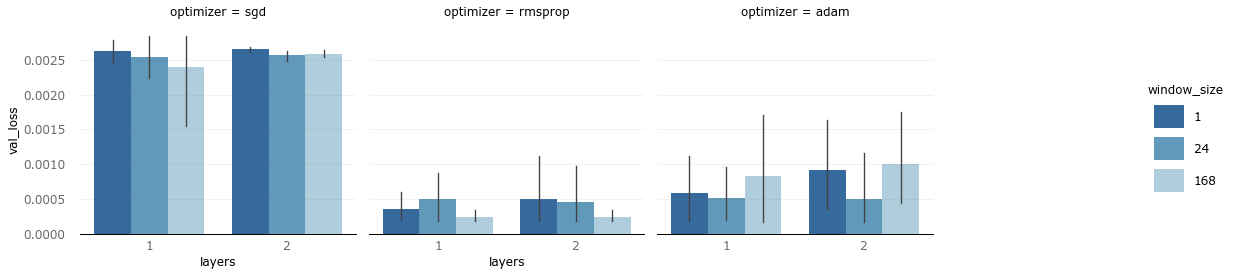

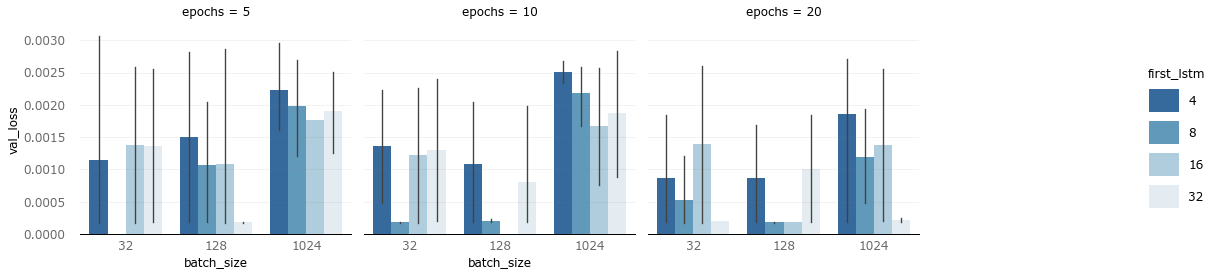

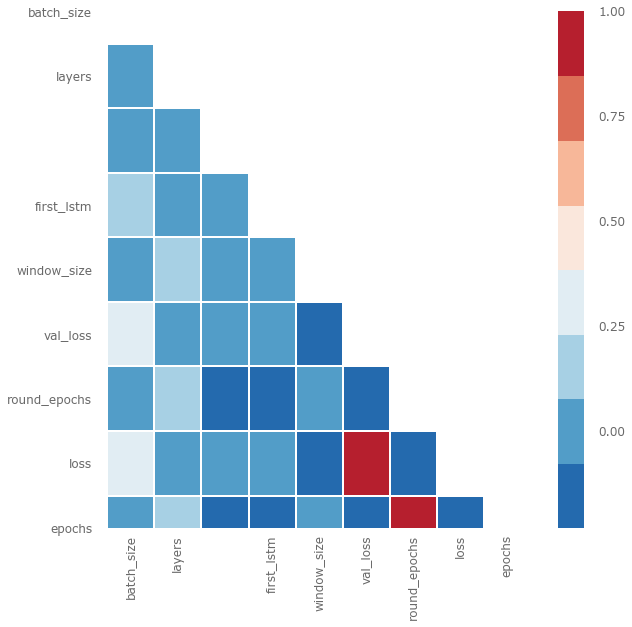

In [45]:
# four dimensional bar grid
analyze_object.plot_bars('layers', 'val_loss', 'window_size', 'optimizer')

# four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_loss', 'first_lstm', 'epochs')

# heatmap correlation
analyze_object.plot_corr('val_loss', [])
